## 任务描述：

### 如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

### 本实践旨在通过一个美食分类的案列，让大家理解和掌握如何使用飞桨动态图搭建一个**卷积神经网络**。

### 特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle.fluid as fluid
import matplotlib.pyplot as plt


2024-01-13 18:36:39,551-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2024-01-13 18:36:40,017-INFO: generated new fontManager


In [2]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 64, 64],                                #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"data/data42610/foods.zip",                    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 2,                                          #训练轮数
    "train_batch_size": 64,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0001                                          #超参数学习率
    } 
}

# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [3]:

def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "foods")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [4]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"foods/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 8 == 0:                                  # 每8张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [5]:

def custom_reader(file_list):
    '''
    自定义reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = img.resize((64, 64), Image.BILINEAR)
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader


In [6]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(custom_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)      #若设置为True，则当最后一个batch不等于batch_size时，丢弃最后一个batch；若设置为False，则不会。默认值为False。
eval_reader = paddle.batch(custom_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)


生成数据列表完成！


# **二、模型配置**



In [7]:

#定义卷积网络
class MyCNN(fluid.dygraph.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.hidden1 = fluid.dygraph.Conv2D(num_channels=3,       #通道数
                                            num_filters=64,       #卷积核个数
                                            filter_size=3,        #卷积核大小
                                            stride=1)             #步长
        self.hidden2 = fluid.dygraph.Conv2D(num_channels=64,
                                            num_filters = 128,
                                            filter_size=3,
                                            stride=1)
        self.hidden3 = fluid.dygraph.Pool2D(pool_size=2,          #池化核大小
                                            pool_type='max',      #池化类型
                                            pool_stride=2)        #池化步长
        self.hidden4 = fluid.dygraph.Linear(128*30*30,5,act='softmax')
    #网络的前向计算过程
    def forward(self,input):
        x = self.hidden1(input)
        #print(x.shape)
        x = self.hidden2(x)
        #print(x.shape)
        x = self.hidden3(x)
        #print(x.shape)
        #卷积层的输出特征图如何当作全连接层的输入使用呢？
        #卷积层的输出数据格式是[N,C,H,W],在输入全连接层的时候，会自动将数据拉平.
        #也就是对每个样本，自动将其转化为长度为K的向量，其中K=C×H×W，一个mini-batch的数据维度变成了N×K的二维向量。
        x = fluid.layers.reshape(x, shape=[-1, 128*30*30])
        y = self.hidden4(x)
        return y

# **三、模型训练 && 四、模型评估**

In [8]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("loss/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

5
{'0': 'baby_back_ribs', '1': 'apple_pie', '2': 'beef_carpaccio', '3': 'beef_tartare', '4': 'baklava'}


W0113 18:36:44.166333   170 device_context.cc:252] Please NOTE: device: 0, CUDA Capability: 70, Driver API Version: 12.0, Runtime API Version: 9.0
W0113 18:36:44.171897   170 device_context.cc:260] device: 0, cuDNN Version: 7.6.


Loss at epoch 0 step 0: [1.7767267], acc: [0.25]
Loss at epoch 0 step 1: [8.619677], acc: [0.171875]
Loss at epoch 0 step 2: [6.244611], acc: [0.203125]
Loss at epoch 0 step 3: [4.287492], acc: [0.265625]
Loss at epoch 0 step 4: [5.0012655], acc: [0.140625]
Loss at epoch 0 step 5: [5.7895], acc: [0.1875]
Loss at epoch 0 step 6: [5.0076075], acc: [0.21875]
Loss at epoch 0 step 7: [3.4122396], acc: [0.234375]
Loss at epoch 0 step 8: [1.973443], acc: [0.21875]
Loss at epoch 0 step 9: [2.8349354], acc: [0.21875]
Loss at epoch 0 step 10: [3.2215884], acc: [0.28125]
Loss at epoch 0 step 11: [3.460835], acc: [0.296875]
Loss at epoch 0 step 12: [3.052576], acc: [0.1875]
Loss at epoch 0 step 13: [2.4865618], acc: [0.296875]
Loss at epoch 0 step 14: [1.9496026], acc: [0.328125]
Loss at epoch 0 step 15: [2.499082], acc: [0.1875]
Loss at epoch 0 step 16: [2.1668081], acc: [0.265625]
Loss at epoch 0 step 17: [1.6086615], acc: [0.3125]
Loss at epoch 0 step 18: [2.1090734], acc: [0.234375]
Loss at ep

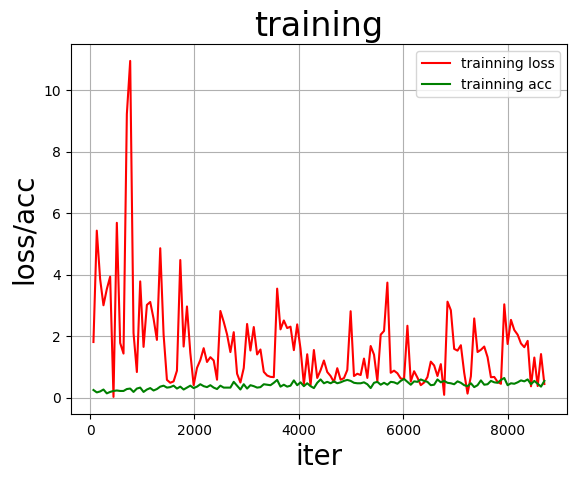

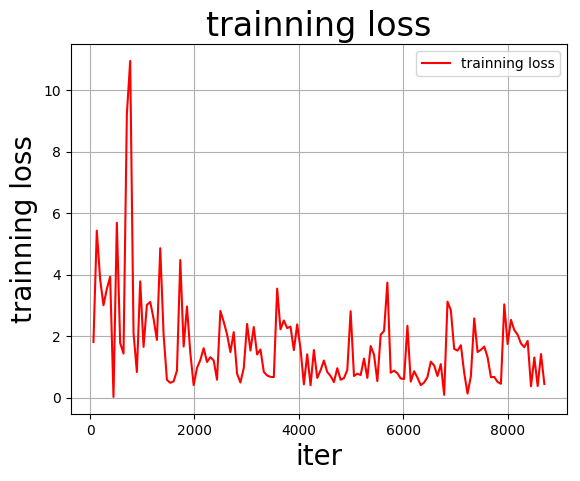

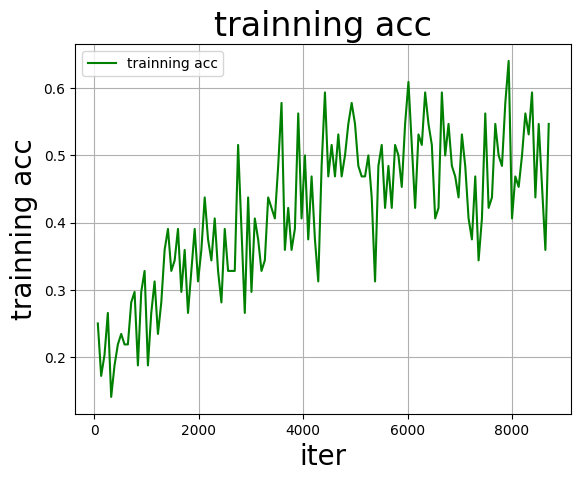

Final loss: [1.1617192]


In [9]:
 

'''
模型训练
'''
#place=fluid.CUDAPlace(0)表示使用GPU进行训练；不设置表示使用CPU进行训练
with fluid.dygraph.guard():   
                            
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])

    cnn = MyCNN()
    optimizer=fluid.optimizer.AdamOptimizer(learning_rate=train_parameters['learning_strategy']['lr'],
                                                parameter_list=cnn.parameters()) 
    for epoch_num in range(train_parameters['num_epochs']):
        for batch_id, data in enumerate(train_reader()):
            dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 64, 64)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out = cnn(img)
            #计算精度和损失
            acc=fluid.layers.accuracy(out,label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)
             
            #将参数梯度清零以保证下一轮训练的正确性
            cnn.clear_gradients()
            
            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
                
            if batch_id % 1 == 0:
                print("Loss at epoch {} step {}: {}, acc: {}".format(epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))
    draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning loss","trainning acc")  
    draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
    draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")
    #保存模型参数
    fluid.save_dygraph(cnn.state_dict(), "cnn")   
    print("Final loss: {}".format(avg_loss.numpy()))


In [10]:
'''
模型校验
'''
with fluid.dygraph.guard():
    model, _ = fluid.load_dygraph("cnn")
    cnn = MyCNN()
    cnn.load_dict(model)
    cnn.eval()
    accs = []
    for batch_id, data in enumerate(eval_reader()):
        # dy_x_data = np.array([x[0] for x in data]).astype('float32')
        # y_data = np.array([x[1] for x in data]).astype('int')
        # y_data = y_data[:, np.newaxis]
        
        dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 64, 64)
        y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)
        
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)

        out = cnn(img)
        acc=fluid.layers.accuracy(out,label)#计算精度
        lab = np.argsort(out.numpy())
        accs.append(acc.numpy()[0])
print(np.mean(accs))

0.46180555


# **五、模型预测**

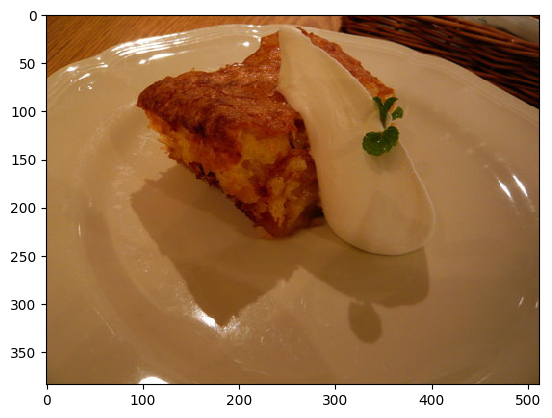

第1个样本,被预测为：apple_pie
结束


In [11]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path + "foods")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((64, 64), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                   # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data42610/foods.zip'
infer_dst_path = '/home/aistudio/data/'
unzip_infer_data(infer_src_path,infer_dst_path)

label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    model, _ = fluid.dygraph.load_dygraph("cnn")
    cnn = MyCNN()
    cnn.load_dict(model)
    cnn.eval()
    
    #展示预测图片
    infer_path='data/foods/apple_pie/64846.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_imgs.append(load_image(infer_path))
    infer_imgs = np.array(infer_imgs)
   
    for  i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = cnn(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
        print("第{}个样本,被预测为：{}".format(i+1,label_dic[str(lab)]))
        
print("结束")
